# WangchanBERTa: Getting Started Notebook


This is a developing Getting Started Notebook for WangchanBERTa. Currently it has inference methods you can easily use from [HuggingFace](http://huggingface.co/). We will add pretraining and finetuning methods from the scripts in [vistec-ai/thai2transformers](https://github.com/vistec-AI/thai2transformers).

![WangchanBERTa](https://miro.medium.com/max/2400/1*XAHtR9rKv8SJ4ESELxm2iQ.png)

# Installation

Install dependencies at specific versions to make sure WangchanBERTa works.

In [ ]:
# Install transformers and thai2transformers
!pip install transformers
!pip install --upgrade pythainlp==2.2.4
!pip install -q emoji pythainlp==2.2.4 sefr_cut tinydb seqeval sentencepiece pydantic jsonlines emoji
!pip install emoji
!pip install seqeval
!pip install --no-deps thai2transformers==0.1.2
!pip install pythainlp

Requested pythainlp==2.2.4 from https://files.pythonhosted.org/packages/c6/19/b7aaa81a93d16281f5a3a86755f37f87cf11f3c2f2a6d7a8f66b82978b60/pythainlp-2.2.4-py3-none-any.whl has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    nltk (>=3.3.*) ; extra == 'full'
          ~~~~~~^
Please use pip<24.1 if you need to use this version.
ERROR: Could not find a version that satisfies the requirement pythainlp==2.2.4 (from versions: 0.0.4, 0.0.5, 0.0.6, 0.0.7, 0.0.8, 0.0.9, 1.0.0, 1.1, 1.2, 1.3, 1.4.1, 1.5, 1.5.1, 1.5.2, 1.5.3, 1.5.4, 1.5.4.1, 1.5.4.2, 1.6.0.2, 1.6.0.3, 1.6.0.4, 1.6.0.5, 1.6.0.6, 1.6.0.7, 1.7.0, 1.7.0.1, 1.7.1, 1.7.2, 1.7.3, 1.7.4, 2.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.1.dev1, 2.1.dev2, 2.1.dev3, 2.1.dev4, 2.1.dev6, 2.1.dev7, 2.1.dev8, 2.1, 2.1.1, 2.1.2, 2.1.3, 2.1.4.dev0, 2.1.4, 2.2.0.dev0, 2.2.0.dev1, 2.2.0b1, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.2.6, 2.3.0.dev0, 2.3.0b1, 2.3.0, 2.3.1.dev0, 2.3.1, 2.3.2, 2.4.0.dev0, 3.0.0.dev0

#PRETRAIN

In [ ]:
import pandas as pd
import numpy as np

#======== Download Dateset ========#
!gdown 1Qm22XvRlWHrT34YO2FHFeRCQ-xlcnTGt

df = pd.read_csv("review_shoppings.csv")
df.head()


Downloading...
From: https://drive.google.com/uc?id=1Qm22XvRlWHrT34YO2FHFeRCQ-xlcnTGt
To: /content/review_shoppings.csv
100% 287k/287k [00:00<00:00, 93.1MB/s]


,text,label
0,เกลียด ชอบหลอกให้สั่งซื้อ ที่ไหนได้ไม่มีสิ้นค้า,p_neg
1,สินค้าด้อยคุณภาพ,p_neg
2,สินค้าหมดทำไมไม่แจ้งขึ้นว่าหมดอะ.กดใส่ตะกร้าไป...,p_neg
3,อย่าทำแบบนี้กับใครอีกนะค่ะแย่มากค่ะ,p_neg
4,คือเเบบผิดหวังมาก เเย่ที่สุดได้ของมาฝาเเตก เเต...,t_neg


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    844 non-null    object
 1   label   844 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB


In [ ]:
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_words
from pythainlp.util import normalize
import re

# โหลดพจนานุกรมไทย
dict_thai = set(thai_words())

# ฟังก์ชันลบคำที่ไม่มีในพจนานุกรม แต่คงช่องว่างไว้
def clean_noise_keep_space(text):
    text = normalize(text)
    words = word_tokenize(text, engine='newmm', keep_whitespace=True)  # สำคัญตรงนี้
    clean_words = [w if w.strip() in dict_thai or w.isspace() else '' for w in words]
    return ' '.join(clean_words)

# ทดสอบ
text = "ดีมากๆๆๆ ำทน่ร ได้เร็ว แพ็คดี"
clean_text = clean_noise_keep_space(text)
print(re.sub(r"\s+"," ",clean_text).strip())

ดีมาก ได้ เร็ว แพ็ค ดี


In [ ]:
import pandas as pd

# โหลดข้อมูล
df = pd.read_csv("/content/review_shoppings.csv")

# เพิ่มคอลัมน์ใหม่ที่ล้างคำไม่มีความหมาย
df["text"] = df["text"].apply(clean_noise_keep_space)

In [ ]:
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoConfig



# 1. Load tokenizer and model
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=6,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

# Load the full dataset from a single CSV file
dataset = load_dataset("csv", data_files="review_shoppings.csv", split="train")

label2id = {"p_pos": 0, "p_neg": 1, "t_neg": 2, "pt_neg": 3, "t_pos": 4, "pt_pos": 5}

def preprocess(example):
    example["label"] = label2id[example["label"]]
    return tokenizer(example["text"],
                     truncation=True,
                     padding="max_length",
                     max_length=128)

encoded_dataset = dataset.map(preprocess)

# Split the dataset: 70% train, 15% validation, 15% test
dataset_split = encoded_dataset.train_test_split(test_size=0.30, seed=42)
test_valid_split = dataset_split['test'].train_test_split(test_size=0.5, seed=42)

# Combine the splits
final_splits = {
    'train': dataset_split['train'],
    'validation': test_valid_split['train'],
    'test': test_valid_split['test']
}

# Check the splits
print(final_splits)

# 3. Preprocess (tokenize)




# 4. Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# 5. Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=50,
    learning_rate=1e-5,
    save_steps=500,
    logging_dir='./logs',
    logging_steps=100,
)

# 6. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_splits["train"],
    eval_dataset=final_splits["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 7. Train
trainer.train()


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/844 [00:00<?, ? examples/s]

{'train': Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 590
}), 'validation': Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 127
}), 'test': Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 127
})}


/tmp/ipython-input-683658563.py:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
100,1.626100
200,1.454700
300,1.347500
400,1.150200
500,1.238000
600,1.135400
700,1.060800
800,0.908300
900,0.907200
1000,0.804000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/p

TrainOutput(global_step=7400, training_loss=0.5228104832365706, metrics={'train_runtime': 1344.5085, 'train_samples_per_second': 21.941, 'train_steps_per_second': 5.504, 'total_flos': 1940513723136000.0, 'train_loss': 0.5228104832365706, 'epoch': 50.0})

In [ ]:
import torch
test_texts = final_splits["validation"]["text"]

texts = test_texts[:]

inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)  # ย้าย model ไป GPU ถ้ามี

inputs = {k: v.to(device) for k, v in inputs.items()}

# 4. Run inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# 5. แปลง logits เป็น label
predicted_class_ids = torch.argmax(logits, dim=-1).tolist()

# สมมุติ label mapping
id2label = {0 : "p_pos",
            1 : "p_neg",
            2 : "t_neg",
            3 : "pt_neg",
            4 : "t_pos",
            5 : "pt_pos"}

predicted_labels = [id2label[i] for i in predicted_class_ids]

# 6. แสดงผลลัพธ์
for text, label in zip(texts, predicted_labels):
    print(f"ข้อความ: {text}\nทำนาย: {label}\n")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


ข้อความ: จัดส่งรวดเร็วค่ะ รองเท้าสวย ไม่มีตำหนิคุณภาพดี ไว้จะมาอุดหนุนใหม่นะคะจัดส่งรวดเร็วค่ะ รองเท้าสวย ไม่มีตำหนิคุณภาพดี ไว้จะมาอุดหนุนใหม่นะคะจัดส่งรวดเร็วค่ะ รองเท้าสวย ไม่มีตำหนิคุณภาพดี ไว้จะมาอุดหนุนใหม่นะคะจัดส่งรวดเร็วค่ะ รองเท้าสวย ไม่มีตำหนิคุณภาพดี ไว้จะมาอุดหนุนใหม่นะคะ
ทำนาย: p_pos

ข้อความ: อร่อย ซ้ำหลายรอบแล้ว

ทำนาย: p_pos

ข้อความ: ได้รับสินค้าไวดีค่ะ แต่ปากกาทัชกับหน้าจอไม่ค่อยติดตามคลิปเลยค่ะ  เวลาจะเขียนงานจกงานจริงๆใช้ไม่ค่อยได้เลยค่ะ เลยรู้สึกว่าไม่คุ้มค่าเท่าไหร่
ทำนาย: p_neg

ข้อความ: มีวันหมดอายุครบ กระปุกไม่เล็กรสชาติดีเคยสั่งแล้ว2ครั้ง คุ้มสุดๆ สั่ง2กป.ลดอีกคุ้มสุดๆ สั่งเรื่อยๆ แน่นอนจ้า
ทำนาย: p_pos

ข้อความ: สภาพแย่มาก ราคา 9 บาทลาก็ขึ้นจะกินได้ยังไง ไม่น่าทำออกมาขายเลย เป็นสินค้าที่แย่ที่สุดใน shopee เลยก็ว่าได้ เอาเปรียบผู้บริโภคมาก
ทำนาย: p_neg

ข้อความ: กางเกงในผู้ชายขาสั้นสีเขียวสีเทาสีดำกางเกงในบ๊อกเซอร์ราคาดีส่งไวและผ้าดีสั่งมาจำนวนทั้งหมด 7 ตัวราคาดีมากคะ
ทำนาย: p_pos

ข้อความ: เสียความรู้สึกค่ะมาไม่ตรงที่สั่ง
ทำนาย: p_neg

ข้อความ: เนื้อผ้าดีแต่

In [ ]:
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoConfig
dataset = load_dataset("csv", data_files="review_shoppings.csv", split="train")
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

label2id = {"p_pos": 0, "p_neg": 1, "t_neg": 2, "pt_neg": 3, "t_pos": 4, "pt_pos": 5}

def preprocess(example):
    example["label"] = label2id[example["label"]]
    return tokenizer(example["text"],
                     truncation=True,
                     padding="max_length",
                     max_length=128)

encoded_dataset = dataset.map(preprocess)

# Split the dataset: 70% train, 15% validation, 15% test
dataset_split = encoded_dataset.train_test_split(test_size=0.30, seed=42)
test_valid_split = dataset_split['test'].train_test_split(test_size=0.5, seed=42)

# Combine the splits
final_splits = {
    'train': dataset_split['train'],
    'validation': test_valid_split['train'],
    'test': test_valid_split['test']
}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/905k [00:00<?, ?B/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

In [ ]:
import torch
test_texts = final_splits["validation"]["text"]

texts = test_texts[:]
# 3. Tokenize ข้อความ
inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = {k: v.to(device) for k, v in inputs.items()}
print(inputs['input_ids'].shape)
print("Text:",texts[2])
print(inputs['input_ids'][2].shape)
print(inputs['input_ids'][2])

torch.Size([127, 105])
Text: ไม่แนะนำซื้อมาใช้ได้วันเดียวใช้ไม่ได้แล้ว
torch.Size([105])
tensor([    5,   729,   890,  4257,  2923,  7402, 13610,    22,     6,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1], device='cuda:0')


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Path where model was saved (after training)
model_path = "/content/results/checkpoint-7400"

# Load tokenizer and model from saved directory
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Create a pipeline for text classification
# clf = pipeline("text-classification", model=model, tokenizer=tokenizer)

test_texts = final_splits["validation"]["text"]

texts = test_texts[:]
# 3. Tokenize ข้อความ
inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)  # ย้าย model ไป GPU ถ้ามี

inputs = {k: v.to(device) for k, v in inputs.items()}
# 4. Run inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# 5. แปลง logits เป็น label
predicted_class_ids = torch.argmax(logits, dim=-1).tolist()

# สมมุติ label mapping
id2label = {0 : "p_pos",
            1 : "p_neg",
            2 : "t_neg",
            3 : "pt_neg",
            4 : "t_pos",
            5 : "pt_pos"}

predicted_labels = [id2label[i] for i in predicted_class_ids]

# 6. แสดงผลลัพธ์
for text, label in zip(texts, predicted_labels):
    print(f"ข้อความ: {text}\nทำนาย: {label}\n")


ข้อความ: ช้า
ทำนาย: p_neg

ข้อความ: ได้รับสินค้าเรียบร้อยแล้วครับส่งของมาใช้ระยะเวลาประมาณสองถึงสามวันตั้งแต่ส่งของส่งของมาถึงแล้วได้รับของเรียบร้อยแล้วถือว่าโอเคใช้ดีดีมากครับระยะเวลาในการส่งเหมาะสมสมควรไม่ช้าเกินไม่นานเกินและไม่เร็วเกินสินค้าสภาพโอเคสภาพสมบูรณ์มาถึงเรียบร้อยดีครับเช็คแล้วถือว่าใช้ได้โอเคมากๆครับเรียบร้อยดีทุกอย่างไม่มีปัญหาอะไรเลยถ้ายังไงจะสั่งใหม่อีกทีนะครับสั่งร้านเดิมครับใครที่สนใจอยู่สั่งได้เลยครับร้านนี้
ทำนาย: pt_pos

ข้อความ: ไม่แนะนำซื้อมาใช้ได้วันเดียวใช้ไม่ได้แล้ว
ทำนาย: p_neg

ข้อความ: ได้สินค้าภายในสองวัน OK นะครับ สมราคา ใช้งานได้ปกติ
ทำนาย: pt_pos

ข้อความ: ใช้ดี ราคาไม่แพงเกินค่ะ พอใจมาก
ทำนาย: p_pos

ข้อความ: ปกติไม่รีวิว อันนี้ยอม ต้องรีวิวจริงๆ ว่า ขนส่งแย่มากกก ส่งของช้า ใส่กันกระแทกมาส่งๆ แบบใส่ให้รู้ว่ามี แต่กันอะไรไม่ได้ หัวขวดถ้าไม่ดีดก็หัก หกเยิ้มไปหมด อันนี้เป็นการซื้อครั้งแรก และคงเป็นครั้งสุดท้ายของร้านนี้ มีเพื่อนรอรีวิว คงบอกเพื่อนได้แค่ว่า ห่อของและขนส่งเห้มาก อย่าไปสั่งเลยดีกว่า
ทำนาย: pt_neg

ข้อความ: ทุกอย่างดีหมด รสชาติอร่อย 
ทำนาย: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Accuracy: 0.78


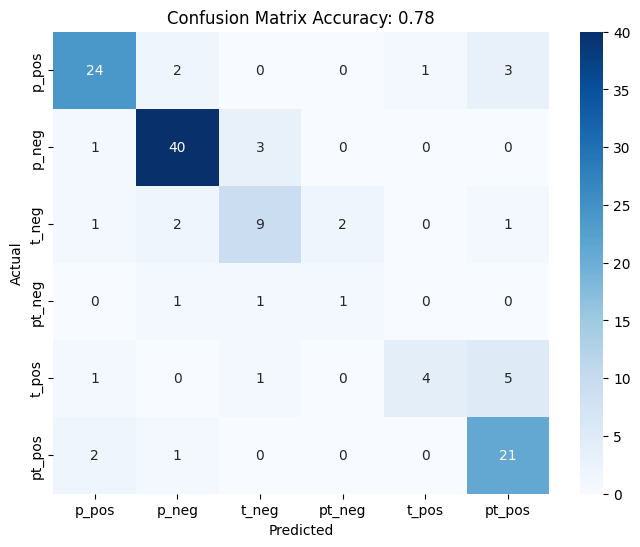

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# สมมุติว่าคุณมี y_true (ค่าจริง) และ y_pred (ค่าที่โมเดลทำนายมา)
# เช่น:
y_trues = final_splits["validation"]
y_true = y_trues["label"]

inputs = tokenizer(y_trues["text"][:], padding=True, truncation=True, max_length=128, return_tensors="pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)  # ย้าย model ไป GPU ถ้ามี

inputs = {k: v.to(device) for k, v in inputs.items()}
# 4. Run inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# 5. แปลง logits เป็น label
predicted_class_ids = torch.argmax(logits, dim=-1).tolist()

y_pred = predicted_class_ids
# คำนวณ confusion matrix
cm = confusion_matrix(y_true, y_pred)

# คำนวณ accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.2f}")

# แสดง confusion matrix เป็น heatmap
labels = ["p_pos", "p_neg", "t_neg", "pt_neg", "t_pos", "pt_pos"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix Accuracy: {acc:.2f}')
plt.show()


In [ ]:
import shutil

# Save Model With Checkpoint path
folder_path = "/content/results/checkpoint-4000"

# Output zip file name
zip_path = "model_archive.zip"

# Create a zip archive from the folder
shutil.make_archive(base_name="model_archive", format="zip", root_dir=folder_path)

'/content/model_archive.zip'

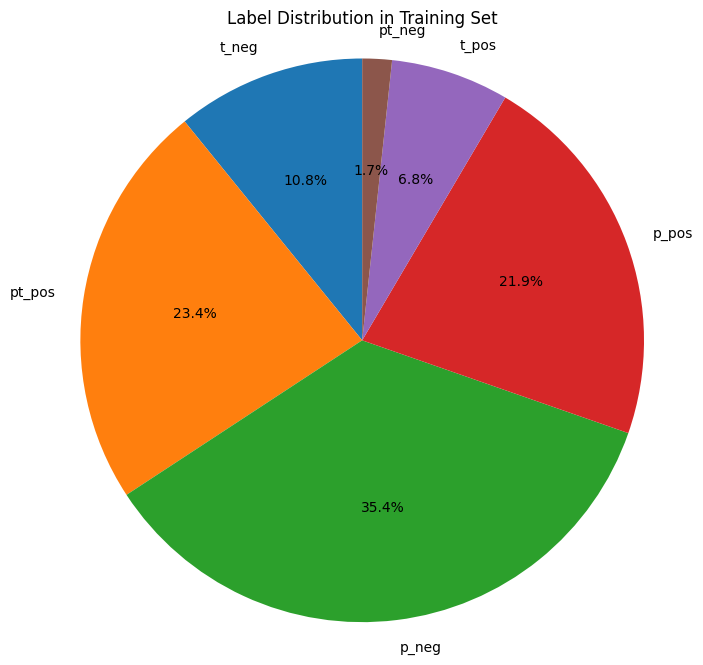

In [ ]:
import matplotlib.pyplot as plt

# Get the label list
labels = final_splits["train"]["label"]

# Count each label
from collections import Counter
label_counts = Counter(labels)

# Create label names from label2id
id2label = {0: "p_pos", 1: "p_neg", 2: "t_neg", 3: "pt_neg", 4: "t_pos", 5: "pt_pos"}
labels_text = [id2label[i] for i in label_counts.keys()]
counts = list(label_counts.values())

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels_text, autopct='%1.1f%%', startangle=90)
plt.title("Label Distribution in Training Set")
plt.axis('equal')  # Equal aspect ratio makes the pie chart round
plt.show()

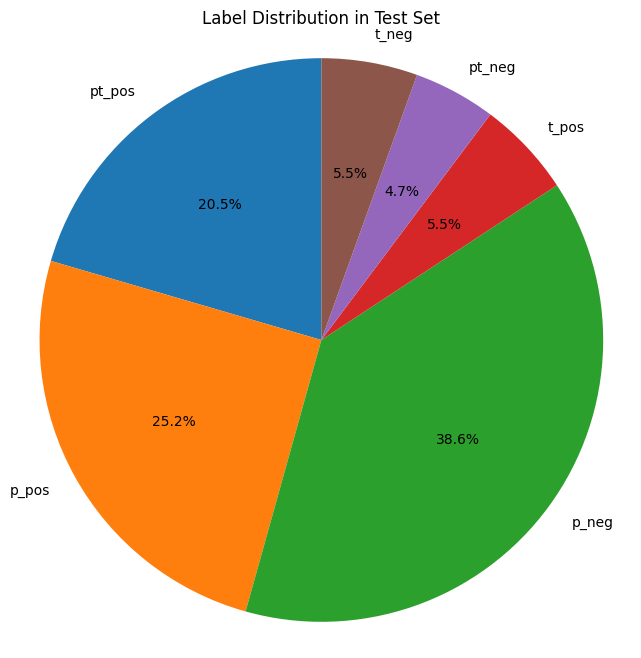

In [ ]:
import matplotlib.pyplot as plt

# Get the label list
labels = final_splits["test"]["label"]

# Count each label
from collections import Counter
label_counts = Counter(labels)

# Create label names from label2id
id2label = {0: "p_pos", 1: "p_neg", 2: "t_neg", 3: "pt_neg", 4: "t_pos", 5: "pt_pos"}
labels_text = [id2label[i] for i in label_counts.keys()]
counts = list(label_counts.values())

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels_text, autopct='%1.1f%%', startangle=90)
plt.title("Label Distribution in Test Set")
plt.axis('equal')  # Equal aspect ratio makes the pie chart round
plt.show()

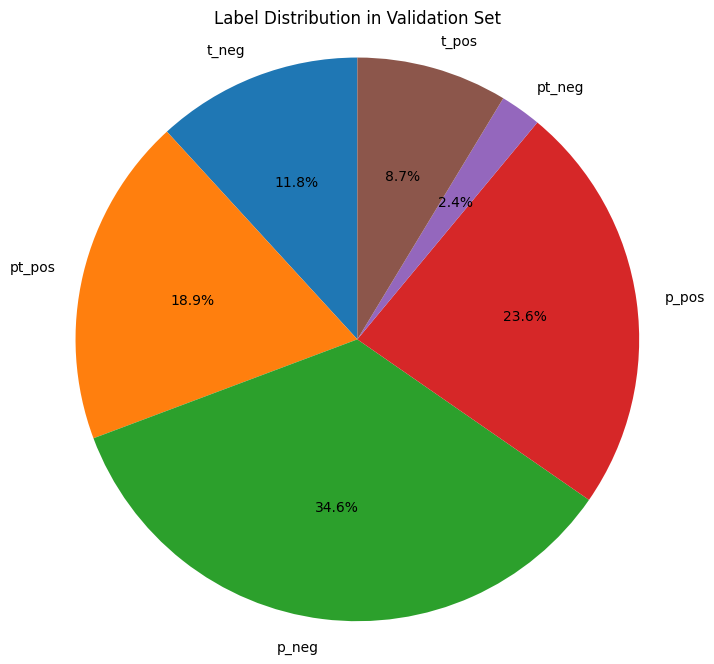

In [ ]:
import matplotlib.pyplot as plt

# Get the label list
labels = final_splits["validation"]["label"]

# Count each label
from collections import Counter
label_counts = Counter(labels)

# Create label names from label2id
id2label = {0: "p_pos", 1: "p_neg", 2: "t_neg", 3: "pt_neg", 4: "t_pos", 5: "pt_pos"}
labels_text = [id2label[i] for i in label_counts.keys()]
counts = list(label_counts.values())

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels_text, autopct='%1.1f%%', startangle=90)
plt.title("Label Distribution in Validation Set")
plt.axis('equal')  # Equal aspect ratio makes the pie chart round
plt.show()

In [ ]:
import shutil

# Folder to zip
folder_to_zip = "/content/results/checkpoint-7400"

# Output zip file path (without .zip extension)
output_zip_path = "/content/results_archive"

# Create ZIP
shutil.make_archive(output_zip_path, 'zip', folder_to_zip)


'/content/results_archive.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mv /content/results_archive.zip /content/drive/MyDrive/

Mounted at /content/drive


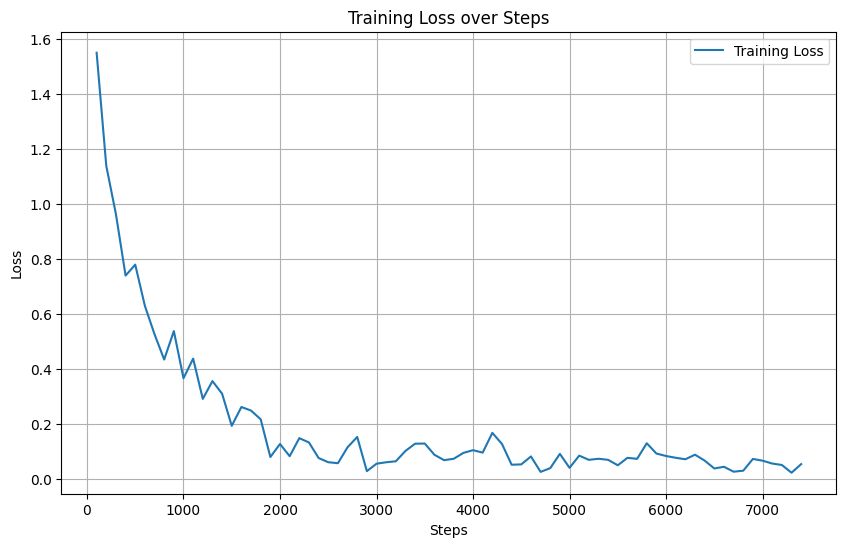

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 105249030


In [ ]:
model

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(25005, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias

In [ ]:
from torchviz import make_dot
dummy_input = tokenizer("ตัวอย่างข้อความ", return_tensors="pt").to(model.device)
output = model(**dummy_input)
make_dot(output.logits, params=dict(model.named_parameters())).render("camembert_structure", format="png")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


'camembert_structure.png'

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
import torch

summary(
    model,
    input_data={
        "input_ids": torch.randint(0, 25005, (1, 128)),          # batch 1, seq len 128
        "attention_mask": torch.ones((1, 128), dtype=torch.int64)
    },
    col_names=["input_size", "output_size", "num_params", "trainable"],
    depth=3,
)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1793: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  result = forward_call(*args, **kwargs)


Layer (type:depth-idx)                                            Input Shape               Output Shape              Param #                   Trainable
CamembertForSequenceClassification                                --                        [1, 6]                    --                        True
├─CamembertModel: 1-1                                             [1, 128]                  [1, 128, 768]             --                        True
│    └─CamembertEmbeddings: 2-1                                   --                        [1, 128, 768]             --                        True
│    │    └─Embedding: 3-1                                        [1, 128]                  [1, 128, 768]             19,203,840                True
│    │    └─Embedding: 3-2                                        [1, 128]                  [1, 128, 768]             768                       True
│    │    └─Embedding: 3-3                                        [1, 128]                  [1, 128, 

In [ ]:
from torchviz import make_dot

inputs = tokenizer("ตัวอย่างข้อความ", return_tensors="pt").to(model.device)
outputs = model(**inputs)
dot = make_dot(outputs.logits, params=dict(model.named_parameters()))
dot.render("model_graph", format="png")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


'model_graph.png'